# Lab4 (Students version): robustness of a graph
## Students:
## Jack Thay - 21201079
## Thierry Ung - 3804472

We can use the following libraries.

In [1]:
import matplotlib.pyplot as plt
import math
import sys
import time # Used to measure our execution time
import random

from collections import deque

print(sys.version)

3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]


In this lab session, we investigate the notion of robustness of a graph: how well a graph remains connected when nodes disappear following random failures or degree-based failures.

## Exercise 1: preliminary work

### Question 1

Using the code seen in previous labs, load the following graph as a dictonary of lists:

http://lioneltabourier.fr/documents/inet.txt

In [2]:
# Code taken from our TP1

def load_graph(filename):
    # Initialize an empty dictionary for the adjacency list.
    adjacency_list = {}
    
    # Open the specified file for reading.
    with open(filename, 'r') as file:
        # Loop through each line in the file.
        for line in file:
            # Check if the line does not start with '#' (comments)
            if not line.startswith('#'):
                # Split the line into two nodes representing an edge.
                edge_info = line.strip().split()
                node1, node2 = edge_info[0], edge_info[1]
                # Check if node1 is not already in the adjacency list.
                if node1 not in adjacency_list:
                    # Initialize an empty list for node1 in the adjacency list.
                    adjacency_list[node1] = []
                # Check if node2 is not already in the adjacency list.
                if node2 not in adjacency_list:
                    # Initialize an empty list for node2 in the adjacency list.
                    adjacency_list[node2] = []
                # Add node2 to the adjacency list of node1 (representing an undirected edge).
                adjacency_list[node1].append(node2)
                # Add node1 to the adjacency list of node2 (since it's an undirected edge).
                adjacency_list[node2].append(node1)

    # Return the adjacency list representing the undirected graph.
    return adjacency_list

In [3]:
# Loading our inet_graph.txt into a variable for easier use down the line
filename = 'inet.txt'
start_time = time.time()
inet_graph = load_graph(filename)
print(f"Graph loaded in {time.time() - start_time:.5f} seconds")

Graph loaded in 0.03125 seconds


### Question 2

Determine the size of the largest connected component (LCC) of a graph, and use the code to determine the size of the LCC of the example graph.

Suggested implementation:

- Create a function that takes a graph as input and outputs a dictionary of the connected component that each node belongs to. (This function is derived from a BFS).

- Then, create another function which takes the dictionary of the connected components as input and computes the size of the largest connected component of the graph.

In [4]:
def bfs(graph, start_node):
    # Initialize a set to keep track of visited nodes
    visited = set()
    # Initialize a deque (double-ended queue) with the starting node
    queue = deque([start_node])
    # Initialize a list to store the connected component (nodes visited during BFS)
    component = []

    # Main BFS loop
    while queue:
        # Get the current node from the front of the queue
        current = queue.popleft()

        # Check if the current node is in the graph
        if current not in graph:
            continue

        # Check if the current node has not been visited
        if current not in visited:
            # Mark the current node as visited
            visited.add(current)
            # Add the current node to the connected component
            component.append(current)
            # Extend the queue with unvisited neighbors of the current node
            queue.extend(node for node in graph[current] if node not in visited)

    # Return the connected component
    return component

In [5]:
def connected_components(graph):
    # Initialize a set to keep track of visited nodes
    visited = set()
    # Initialize a list to store connected components
    components = []

    # Iterate through all vertices in the graph
    for node in graph:
        # Check if the node has not been visited
        if node not in visited:
            # Use BFS to find the connected component starting from the current node
            component = bfs(graph, node)
            # Append the connected component to the list of components
            components.append(component)
            # Mark all nodes in the component as visited
            visited.update(component)

    # Return the list of connected components
    return components

In [6]:
def process_graph(graph):
    start_time = time.time()
    # Find the largest connected component
    components = connected_components(graph)
    largest_component = max(components, key=len)
    
    # Display the largest connected component
    if len(largest_component) > 10:
        print(f"Largest connected component: {largest_component[:10]}...{largest_component[-10:]}")
    else:
        print(f"Largest connected component: {largest_component}")
    
    print(f"\nSize of the largest connected component: {len(largest_component)}")
    print("\nAll connected components:")
    
    # Display all connected components
    for i, component in enumerate(components, 1):
        if len(component) > 10:
            print(f"Component {i}: {component[:10]}...{component[-10:]}")
        else:
            print(f"Component {i}: {component}")
    
    print(f"\nConnected components found in {time.time() - start_time:.5f} seconds")

In [7]:
graph = inet_graph
result = process_graph(graph)

Largest connected component: ['0', '1882', '7203', '5853', '6239', '1888', '7163', '7167', '7204', '7206']...['1715', '1717', '1718', '1719', '6903', '3950', '3948', '1714', '1716', '1713']

Size of the largest connected component: 8557

All connected components:
Component 1: ['0', '1882', '7203', '5853', '6239', '1888', '7163', '7167', '7204', '7206']...['1715', '1717', '1718', '1719', '6903', '3950', '3948', '1714', '1716', '1713']
Component 2: ['2', '7880', '7881', '7882', '7878', '7879']
Component 3: ['19', '25', '3178', '3180', '3242', '28', '29', '27', '26']
Component 4: ['20', '3253', '23', '22', '3235', '3177', '3179', '3256', '3250', '3236']...['3266', '3267', '3268', '3269', '3270', '3271', '3272', '3273', '3274', '3276']
Component 5: ['24', '3252', '3246']
Component 6: ['160', '161']
Component 7: ['171', '172', '173', '4743', '174', '175', '176', '177', '178', '179']...['172', '173', '4743', '174', '175', '176', '177', '178', '179', '180']
Component 8: ['184', '185', '4429']

## Exercise 2: robustness to random failures

### Question 3

In this question, we plot the size of the LCC as a function of the number of nodes removed. 

Nodes are removed randomly. It is a way to evaluate the robustness of the network to random failures.

Suggested implementation:

- create a function that deletes $n_s$ nodes from the original graph

- use the function of Question 2 to compute the size of the LCC

- combine these two functions and iterate to get a dictionary which keys are $n_s$ and values are the corresponding size of the LCC




In [8]:
def remove_nodes(graph, num_nodes_to_remove):
    # Dictionary to store LCC sizes for each iteration
    lcc_sizes = {}

    # Loop through the specified number of nodes to remove
    for ns in range(num_nodes_to_remove):
        # Create a copy of the original graph to avoid modifying it directly
        modified_graph = graph.copy()

        # Remove ns nodes randomly from the graph
        nodes_to_remove = random.sample(list(modified_graph.keys()), ns)

        # Uncomment the next line to print the nodes being removed
        # print(f"Nodes to remove: {nodes_to_remove}")

        # Iterate through nodes to be removed and delete them from the graph
        for node in nodes_to_remove:
            # Check if the node exists before deleting it
            if node in modified_graph:
                del modified_graph[node]
            else:
                print(f"Node {node} not found in the graph")

        # Calculate the size of the largest connected component (LCC)
        components = connected_components(modified_graph)
        largest_component = max(components, key=len)
        lcc_sizes[ns] = len(largest_component)

    # Return the dictionary of LCC sizes for each iteration
    return lcc_sizes

In [9]:
def test_remove_nodes(graph, num_nodes_to_remove):
    start_time = time.time()
    lcc_sizes_dict = remove_nodes(graph, num_nodes_to_remove)

    # Print only the first 10 and last 10 items
    print("First 10 items:")
    for ns, size in list(lcc_sizes_dict.items())[:10]:
        print(f"Nodes Removed: {ns}, LCC Size: {size}")

    print("\nLast 10 items:")
    for ns, size in list(lcc_sizes_dict.items())[-10:]:
        print(f"Nodes Removed: {ns}, LCC Size: {size}")

    print(f"\nExecution done in {time.time() - start_time:.5f} seconds")

In [10]:
graph = inet_graph
num_nodes_to_remove = 100
result = test_remove_nodes(graph, num_nodes_to_remove)

First 10 items:
Nodes Removed: 0, LCC Size: 8557
Nodes Removed: 1, LCC Size: 8554
Nodes Removed: 2, LCC Size: 8552
Nodes Removed: 3, LCC Size: 8550
Nodes Removed: 4, LCC Size: 8554
Nodes Removed: 5, LCC Size: 8551
Nodes Removed: 6, LCC Size: 8548
Nodes Removed: 7, LCC Size: 8541
Nodes Removed: 8, LCC Size: 8552
Nodes Removed: 9, LCC Size: 8551

Last 10 items:
Nodes Removed: 90, LCC Size: 8357
Nodes Removed: 91, LCC Size: 8159
Nodes Removed: 92, LCC Size: 8438
Nodes Removed: 93, LCC Size: 8443
Nodes Removed: 94, LCC Size: 8351
Nodes Removed: 95, LCC Size: 8281
Nodes Removed: 96, LCC Size: 8346
Nodes Removed: 97, LCC Size: 8414
Nodes Removed: 98, LCC Size: 8328
Nodes Removed: 99, LCC Size: 8406

Execution done in 1.41585 seconds


## Exercise 3: robustness to targeted (degree-based) failures 

### Question 4

In this question, we do the same as in the previous question, except for the fact that nodes are not chosen randomly, but by decreasing degree order.

Suggested implementation:

- create a function that outputs a list of nodes ordered by decreasing degree

- then follow the same principle as in the previous question

In [11]:
def nodes_by_degree(graph):
    # Sort nodes by their degree in descending order
    sorted_nodes = sorted(graph, key=lambda x: len(graph[x]), reverse=True)
    return sorted_nodes

In [12]:
def remove_nodes_by_degree(graph, num_nodes_to_remove):
    # Dictionary to store LCC sizes for each iteration
    lcc_sizes = {}

    # Get nodes ordered by decreasing degree
    nodes_ordered_by_degree = nodes_by_degree(graph)

    # Loop through the specified number of nodes to remove
    for ns in range(num_nodes_to_remove):
        # Create a copy of the original graph to avoid modifying it directly
        modified_graph = graph.copy()

        # Remove ns nodes from the graph in decreasing degree order
        nodes_to_remove = nodes_ordered_by_degree[:ns]

        # Iterate through nodes to be removed and delete them from the graph
        for node in nodes_to_remove:
            # Check if the node exists before deleting it
            if node in modified_graph:
                del modified_graph[node]

        # Calculate the size of the largest connected component (LCC)
        components = connected_components(modified_graph)
        largest_component = max(components, key=len)
        lcc_sizes[ns] = len(largest_component)

    # Return the dictionary of LCC sizes for each iteration
    return lcc_sizes

In [13]:
def test_remove_nodes_by_degree(graph, num_nodes_to_remove):
    start_time = time.time()
    lcc_sizes_dict = remove_nodes_by_degree(graph, num_nodes_to_remove)

    # Print only the first 10 and last 10 items
    print("First 10 items:")
    for ns, size in list(lcc_sizes_dict.items())[:10]:
        print(f"Nodes Removed: {ns}, LCC Size: {size}")

    print("\nLast 10 items:")
    for ns, size in list(lcc_sizes_dict.items())[-10:]:
        print(f"Nodes Removed: {ns}, LCC Size: {size}")

    print(f"\nExecution done in {time.time() - start_time:.5f} seconds")

In [14]:
graph = inet_graph  
num_nodes_to_remove = 100
result = test_remove_nodes_by_degree(graph, num_nodes_to_remove)

First 10 items:
Nodes Removed: 0, LCC Size: 8557
Nodes Removed: 1, LCC Size: 8556
Nodes Removed: 2, LCC Size: 8497
Nodes Removed: 3, LCC Size: 8497
Nodes Removed: 4, LCC Size: 8497
Nodes Removed: 5, LCC Size: 8497
Nodes Removed: 6, LCC Size: 8497
Nodes Removed: 7, LCC Size: 8497
Nodes Removed: 8, LCC Size: 8497
Nodes Removed: 9, LCC Size: 8497

Last 10 items:
Nodes Removed: 90, LCC Size: 8281
Nodes Removed: 91, LCC Size: 8281
Nodes Removed: 92, LCC Size: 8281
Nodes Removed: 93, LCC Size: 8281
Nodes Removed: 94, LCC Size: 8281
Nodes Removed: 95, LCC Size: 8281
Nodes Removed: 96, LCC Size: 8281
Nodes Removed: 97, LCC Size: 8281
Nodes Removed: 98, LCC Size: 8281
Nodes Removed: 99, LCC Size: 8281

Execution done in 1.45634 seconds


### Question 5

Compare the two curves (random deletions and targeted deletions): are they different? What does it mean?

In [17]:
def plot_graph_random_targeted(graph, num_nodes_to_remove):
    # Calculate the LCC sizes for random deletions
    random_deletions = remove_nodes(graph, num_nodes_to_remove)

    # Calculate the LCC sizes for targeted deletions
    targeted_deletions = remove_nodes_by_degree(graph, num_nodes_to_remove)

    # Set up the plot figure
    plt.figure(figsize=(10, 6))

    # Extract the x and y values for each curve
    x_random = list(random_deletions.keys())
    y_random = list(random_deletions.values())

    x_targeted = list(targeted_deletions.keys())
    y_targeted = list(targeted_deletions.values())

    # Plot the curves for random and targeted deletions
    plt.plot(x_random, y_random, label='Random Deletions')
    plt.plot(x_targeted, y_targeted, label='Targeted Deletions')

    # Add labels and title to the plot
    plt.xlabel('Number of Nodes Removed')
    plt.ylabel('Size of Largest Connected Component (LCC)')
    plt.title('Comparison of Random Deletions and Targeted Deletions')

    # Add a legend to distinguish the curves
    plt.legend()

    # Display the plot
    plt.show()

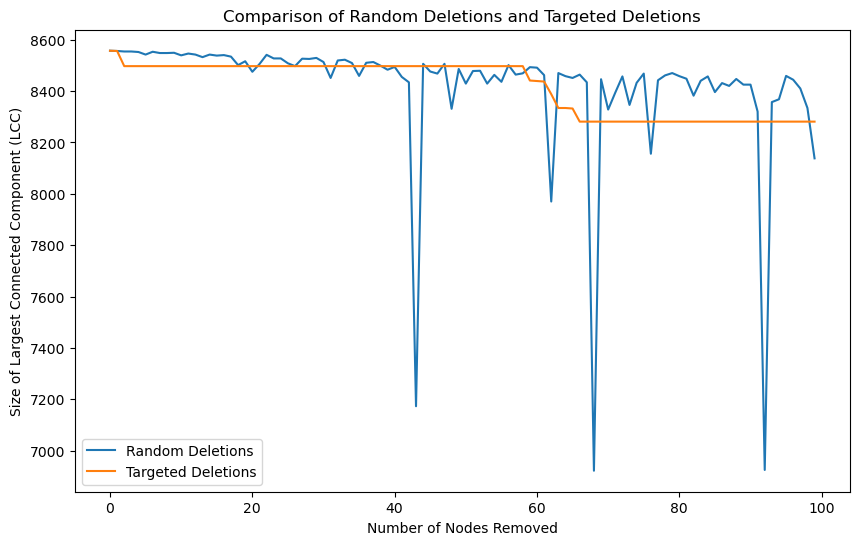

In [18]:
graph = inet_graph
num_nodes_to_remove = 100
result = plot_graph_random_targeted(graph, num_nodes_to_remove)

### Answer: 
Comparing the graphs for random deletions and targeted deletions can give us an idea on how the network structure responds to different node removal strategies.

#### Random Deletions:

The graph for random deletions will most likely show a gradual decline in the size of the Largest Connected Component (LCC) as more nodes are removed.    
Random deletions represents a scenario where nodes fail randomly in the network. If the decline is gradual, we can suppose that the network is more or less robust to random failures, we can the conclude that the network is resilient to the loss of nodes.
    
#### Targeted Deletions (Decreasing Degree Order):

The graph for targeted deletions will show us a more immediate decline compared to the previous strategy, random deletions.    
Targeted deletions in decreasing degree order simulate a scenario where nodes with many connections are specifically removed. If the decline is sudden, it indicates that the network is sensitive to the removal of high-degree nodes.    
This might mean that the network has a core structure which depends heavily on high-degree nodes, and their removal has a significant impact on connectivity.

#### Comparison:

If the line for targeted deletions drops more quickly than the line for random deletions, it is safe to assume that the network is more vulnerable to the removal of high-degree nodes than to random node failures.
If both lines drop similarly, it might tell us that the network's robustness is not strongly affected by the degree distribution.
In conclusion, this comparison helps us understand how the network's structure changes its robustness to different types of failures. It tells us whether the network is more resilient to random failures or whether it has critical nodes that, when removed strategically, lead to a more significant degradation on connectivity.

### Question 6

Do the same thing but now with targeted (closeness and betweenness based) failures


In [19]:
def closeness_centrality(graph, node, component_set):
    # Check if the component_set has more than one node
    if len(component_set) > 1:
        # If there are multiple nodes in the component_set, calculate closeness centrality
        # Closeness centrality is defined as the reciprocal of the sum of distances to all other nodes in the component_set
        # (excluding the current node)
        return 1 / sum(1 for neigh in component_set if neigh != node)
    else:
        # If there is only one node in the component_set, closeness centrality is 0
        return 0

In [20]:
def nodes_by_closeness(graph):
    # Sort nodes in the graph based on their closeness centrality in descending order
    # The key for sorting is the closeness_centrality function applied to each node
    # Closeness centrality is calculated for each node using the set of its neighbors in the graph
    return sorted(graph, key=lambda x: closeness_centrality(graph, x, set(graph[x])), reverse=True)


In [21]:
def remove_nodes_by_closeness(graph, num_nodes_to_remove):
    # Dictionary to store the sizes of the largest connected components (LCC) after each removal
    lcc_sizes = {}

    # Loop through the specified number of nodes to remove
    for ns in range(num_nodes_to_remove):
        # Create a modified graph where each node is removed from its own neighbors
        modified_graph = {node: set(neighbors) - {node} for node, neighbors in graph.items()}

        # Get nodes ordered by closeness centrality in the modified graph
        nodes_ordered_by_closeness = nodes_by_closeness(modified_graph)
        
        # Select nodes to remove based on their closeness centrality order
        nodes_to_remove = nodes_ordered_by_closeness[:ns]

        # Remove selected nodes from the modified graph
        for node in nodes_to_remove:
            if node in modified_graph:
                del modified_graph[node]
                # Update neighbors of remaining nodes to exclude the removed node
                for neighbors in modified_graph.values():
                    neighbors.discard(node)

        # Find connected components in the modified graph
        components = connected_components(modified_graph)

        # Find the largest connected component
        largest_component = max(components, key=len)

        # Store the size of the largest connected component after the current removal
        lcc_sizes[ns] = len(largest_component)

    # Return the dictionary containing the sizes of the largest connected components after each removal
    return lcc_sizes

In [22]:
def test_remove_nodes_by_closeness(graph, num_nodes_to_remove):
    start_time = time.time()
    lcc_sizes_dict = remove_nodes_by_closeness(graph, num_nodes_to_remove)

    # Print only the first 10 and last 10 items
    print("First 10 items:")
    for ns, size in list(lcc_sizes_dict.items())[:10]:
        print(f"Nodes Removed: {ns}, LCC Size: {size}")

    print("\nLast 10 items:")
    for ns, size in list(lcc_sizes_dict.items())[-10:]:
        print(f"Nodes Removed: {ns}, LCC Size: {size}")

    print(f"\nExecution done in {time.time() - start_time:.5f} seconds")

In [23]:
# This time the graph is not as heavy as the graphs from the previous lab session
graph = inet_graph  
num_nodes_to_remove = 100
result = test_remove_nodes_by_closeness(graph, num_nodes_to_remove)

First 10 items:
Nodes Removed: 0, LCC Size: 8557
Nodes Removed: 1, LCC Size: 8556
Nodes Removed: 2, LCC Size: 8555
Nodes Removed: 3, LCC Size: 8554
Nodes Removed: 4, LCC Size: 8553
Nodes Removed: 5, LCC Size: 8552
Nodes Removed: 6, LCC Size: 8552
Nodes Removed: 7, LCC Size: 8552
Nodes Removed: 8, LCC Size: 8552
Nodes Removed: 9, LCC Size: 8552

Last 10 items:
Nodes Removed: 90, LCC Size: 8453
Nodes Removed: 91, LCC Size: 8452
Nodes Removed: 92, LCC Size: 8450
Nodes Removed: 93, LCC Size: 8448
Nodes Removed: 94, LCC Size: 8446
Nodes Removed: 95, LCC Size: 8445
Nodes Removed: 96, LCC Size: 8444
Nodes Removed: 97, LCC Size: 8443
Nodes Removed: 98, LCC Size: 8442
Nodes Removed: 99, LCC Size: 8441

Execution done in 7.90215 seconds


### Question 7

Which measure is the fastest one to disconnect the network?


The fastest measure to disconnect a network in the context of a network's robustness is to remove the node with the highest centrality. Centrality is a measure of how important a node is to the overall network structure. There are many different centrality measures, but some of the most common ones include degree centrality, betweenness centrality, and closeness centrality.

Degree centrality is the simplest measure of centrality, and it is simply the number of links that a node has to other nodes. Betweenness centrality measures how often a node lies on the shortest path between two other nodes. Closeness centrality measures how close a node is to all other nodes in the network.

Removing the node with the highest centrality is likely to have the most disruptive effect on the network, as it will disconnect the largest number of other nodes. This is because the node with the highest centrality is likely to be a hub, meaning that it has many connections to other nodes.

However, it is important to note that the fastest measure to disconnect a network may not always be the most effective measure. For example, if the node with the highest centrality is a critical node in the network, such as a router or server, removing it may cause the entire network to fail. In such cases, it may be better to remove a different node, even if it is not the most central node.